# Example for one region (bundesland)


The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [29]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Now to the fun stuff, we import our module!

In [30]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

## Data retrieval

The next thing we want to do is load a dataset from somewhere. For now there are two different sources i.e. the robert koch institute and the johns hopkins university. We will chose the rki for now!

In [31]:
jhu = cov19.data_retrieval.JHU()
#It is important to download the dataset!
#One could also parse true to the constructor of the class to force an auto download
jhu.download_all_available_data(); 

Wait for the download to finish. It will print a message!

We can now access this downloaded data by the attribute
```
rki.data
```
but normaly one would use the build in filter methods.
For example one could use
```
rki.get_confirmed()
rki.get_deaths()
rki.get_recovered()
```
to get different cases. One could also filter the output, possible args are: bundesland, landkreis, begin_date, end_date, date_type.

## Create the model

First set the variables and priors for the change points:

In [39]:
#Create dates for filter
bd = datetime.datetime(2020,3,4)
ed = datetime.datetime(2020,5,6)

total_cases = jhu.get_confirmed(country="Italy",begin_date=bd,end_date=ed)
print("total_cases", total_cases)

total_cases = np.array(total_cases).reshape(total_cases.shape[0])
# print("total_cases", total_cases)

new_cases_obs = np.diff(np.array(total_cases))
# print("new_cases_obs", new_cases_obs)
date_begin_data = datetime.datetime(2020,3,4)
date_end_data   = datetime.datetime(2020,5,6)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10
# All sporting event cancelled in italy
prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)

# Nation wide lockdown
prior_date_strong_dist_begin =  datetime.datetime(2020,3,21)
#Lockdown extended tiil  3 May
prior_date_contact_ban_begin =  datetime.datetime(2020,4,10)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

total_cases             confirmed
date                 
2020-03-04       3089
2020-03-05       3858
2020-03-06       4636
2020-03-07       5883
2020-03-08       7375
...               ...
2020-05-02     209328
2020-05-03     210717
2020-05-04     211938
2020-05-05     213013
2020-05-06     214457

[64 rows x 1 columns]


Then, create the model:

In [40]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 60475069) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8, pr_I_begin=3090 )
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


## MCMC sampling

In [41]:
trace = pm.sample(model=model, tune=800, draws=800, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 581.05:  12%|█▏        | 23698/200000 [02:13<16:31, 177.74it/s]
Convergence achieved at 23700
INFO     [pymc3.variational.inference] Convergence achieved at 23700
Interrupted at 23,699 [11%]: Average Loss = 686.22
INFO     [pymc3.variational.inference] Interrupted at 23,699 [11%]: Average Loss = 686.22
Multiprocess sampling (2 chains in 2 jobs)
INFO     [pymc3] Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin, mu, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_3, transient_day_2, transient_day_1, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin, mu, transient_len_3_log, transient_len_2_lo

## Plotting

Plotting tools are rudimentary right now. But one can always write custom plotting function 
by accessing the samples stored in the trace.

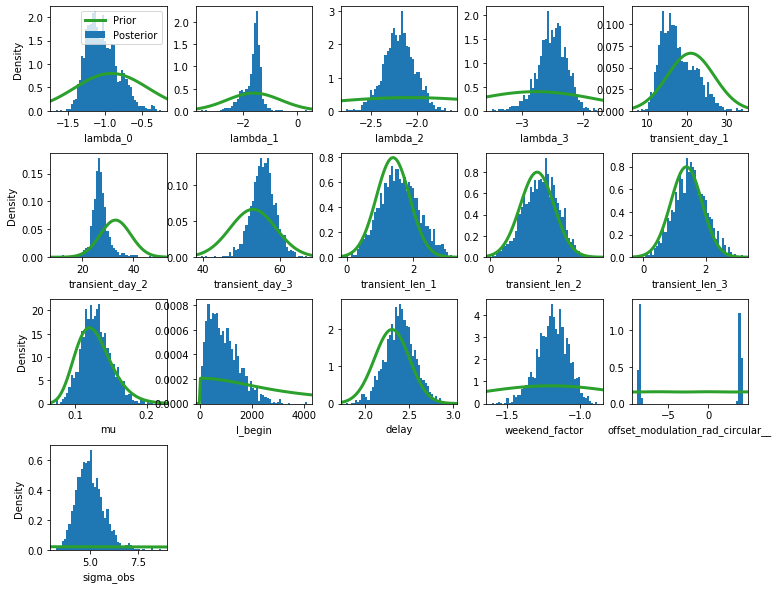

In [53]:
varnames = cov19.plotting.get_all_free_RVs_names(model)

num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0

for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:green', 'tab:blue'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        ax.set_xlabel(varnames[i_ax].replace("_log", ""))
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

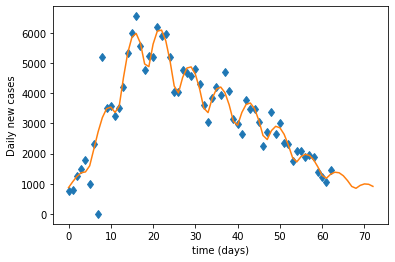

In [43]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

In [49]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

(<Figure size 648x360 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29cd87b8>,
       dtype=object))

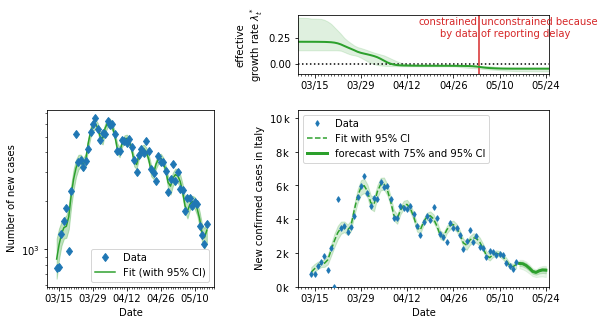

In [50]:
ed = datetime.datetime(2020,5,25)
bg = datetime.datetime(2020,3,10)
cov19.plotting.plot_cases(
    trace,
    new_cases_obs,
    date_begin_sim=bg,
    diff_data_sim = 4,
    start_date_plot=bg,
    end_date_plot=ed,
    ylim=None,
    week_interval=None,
    colors=("tab:blue", "tab:green"),
    country="Italy",
)
